# Flight Pricing Analysis for Flight Price Prediction Dataset (Second Phase)

##### Loading the Dataframe

In [0]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/apeacock@lassencollege.edu/Clean_Dataset_FlightPrices.csv")


#### Importing Dependencies

In [0]:
# Spark SQL and data processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, dayofweek
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F

# For machine learning
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler

# For data visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Initialize Spark session
spark = SparkSession.builder.appName("Flight Recommendation System").getOrCreate()

In [0]:
df.show(5)

+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
+---+--------+-------+-----------+------

#### Data Cleaning & Preprocessing

We removed the index column, departure time, stops (handled nicely by flight duration, no need to double up), departure time and arrival time (covered by flight duration as well). This will simplify and streamline the rest of the operations, without sacrificing insights. In this block we also remove outliers using IQR methods, apply StringIndexer to categorical columns, and showing the indexed results.

In [0]:

# Filter out rows where the class is not 'Economy'
df = df.filter(df['class'] == 'Economy')

# Convert 'duration' and 'days_left' from string to numeric types before dropping any columns
df = df.withColumn("duration", F.col("duration").cast(FloatType())) \
       .withColumn("days_left", F.col("days_left").cast(IntegerType()))

# Define a function to calculate IQR for outlier removal
def calculate_iqr(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    return quantiles[0] - 1.5 * (quantiles[1] - quantiles[0]), quantiles[1] + 1.5 * (quantiles[1] - quantiles[0])

# Remove outliers using the IQR method for 'duration' and 'days_left'
for column in ["duration", "days_left"]:
    lower_bound, upper_bound = calculate_iqr(df, column)
    df = df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))

# Drop the specified columns from the DataFrame after dealing with outliers and casting
columns_to_drop = ['_c0', 'flight', 'departure_time', 'arrival_time', 'stops', 'class']
df = df.drop(*columns_to_drop).na.drop()  # Also, remove rows with null values

# Apply StringIndexer on the remaining categorical columns
categorical_cols = ["airline", "source_city", "destination_city"]  # Adjust based on remaining columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_cols]

# Apply the indexers using a pipeline
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Show the first few rows of the cleaned and indexed DataFrame to confirm changes
df.show(5)

+--------+-----------+----------------+--------+---------+-----+-------------+-----------------+----------------------+
| airline|source_city|destination_city|duration|days_left|price|airline_index|source_city_index|destination_city_index|
+--------+-----------+----------------+--------+---------+-----+-------------+-----------------+----------------------+
|SpiceJet|      Delhi|          Mumbai|    2.17|        1| 5953|          5.0|              0.0|                   1.0|
|SpiceJet|      Delhi|          Mumbai|    2.33|        1| 5953|          5.0|              0.0|                   1.0|
| AirAsia|      Delhi|          Mumbai|    2.17|        1| 5956|          4.0|              0.0|                   1.0|
| Vistara|      Delhi|          Mumbai|    2.25|        1| 5955|          0.0|              0.0|                   1.0|
| Vistara|      Delhi|          Mumbai|    2.33|        1| 5955|          0.0|              0.0|                   1.0|
+--------+-----------+----------------+-

#### Summary Statistics  -- Price

In [0]:
from pyspark.sql.types import IntegerType, FloatType

# Convert 'price' to a numeric type if necessary, here assuming FloatType for generality
df = df.withColumn("price", df["price"].cast(FloatType()))

# Summary statistics for the 'price' column
price_summary = df.describe('price')
price_summary.show()

# Explore data samples near the minimum and maximum prices
min_price = df.select('price').agg(F.min('price')).first()[0]
max_price = df.select('price').agg(F.max('price')).first()[0]
print("Minimum price:", min_price)
print("Maximum price:", max_price)

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            203748|
|   mean| 6513.162715707639|
| stddev|3694.6830092190016|
|    min|            1105.0|
|    max|           42349.0|
+-------+------------------+

Minimum price: 1105.0
Maximum price: 42349.0


#### Summary Statistics -- Duration

In [0]:
from pyspark.sql.types import IntegerType, FloatType


# Convert 'duration' to a numeric type if necessary, here assuming FloatType for generality
df = df.withColumn("duration", df["duration"].cast(FloatType()))

# Summary statistics for the 'duration' column
duration_summary = df.describe('duration')
duration_summary.show()

# Explore data samples near the minimum and maximum durations
min_duration = df.select('duration').agg(F.min('duration')).first()[0]
max_duration = df.select('duration').agg(F.max('duration')).first()[0]
print("Minimum duration:", min_duration)
print("Maximum duration:", max_duration)

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|            203748|
|   mean|11.258966125696935|
| stddev| 6.860568659327309|
|    min|              0.83|
|    max|             28.42|
+-------+------------------+

Minimum duration: 0.8299999833106995
Maximum duration: 28.420000076293945


#### Distribution of categorical variables

In [0]:
# Count flights per airline
df.groupBy('airline').count().show()

# Count flights per source city
df.groupBy('source_city').count().show()

# Count flights per destination city
df.groupBy('destination_city').count().show()

+---------+-----+
|  airline|count|
+---------+-----+
|   Indigo|43120|
| SpiceJet| 9011|
|Air_India|45923|
|  AirAsia|16098|
| GO_FIRST|23173|
|  Vistara|66423|
+---------+-----+

+-----------+-----+
|source_city|count|
+-----------+-----+
|     Mumbai|40687|
|      Delhi|42705|
|  Bangalore|35045|
|    Kolkata|32268|
|  Hyderabad|27634|
|    Chennai|25409|
+-----------+-----+

+----------------+-----+
|destination_city|count|
+----------------+-----+
|       Bangalore|34410|
|         Chennai|26734|
|          Mumbai|39486|
|         Kolkata|34198|
|           Delhi|40387|
|       Hyderabad|28533|
+----------------+-----+



#### Relationships between Variables

In [0]:

# Average price per number of days left
df.groupBy('days_left').avg('price').orderBy('days_left').show()

# Average Duration per Source City
df.groupBy('source_city').avg('duration').orderBy('source_city').show()

# Average Price per Duration
df.groupBy('duration').avg('price').orderBy('duration').show()



+---------+------------------+
|days_left|        avg(price)|
+---------+------------------+
|        1|14477.654761904761|
|        2|13820.137440758293|
|        3|13076.267083027185|
|        4|10826.907151442309|
|        5| 10547.53035610041|
|        6|10260.817769477055|
|        7|10392.741318020235|
|        8|10410.150213447172|
|        9| 11279.67100166021|
|       10| 11128.02500658068|
|       11| 9528.265447813006|
|       12| 9250.924689083371|
|       13| 9307.386669710111|
|       14|  9370.29488372093|
|       15|  8318.17258176757|
|       16| 6237.553849787435|
|       17| 6109.338047445255|
|       18| 5392.020485415275|
|       19| 5298.351285460993|
|       20| 5244.767765075096|
+---------+------------------+
only showing top 20 rows

+-----------+------------------+
|source_city|     avg(duration)|
+-----------+------------------+
|  Bangalore|10.832517335770014|
|    Chennai|11.612701801216126|
|      Delhi|10.788561993716625|
|  Hyderabad|11.233060000694168|

#### Average price vs days left

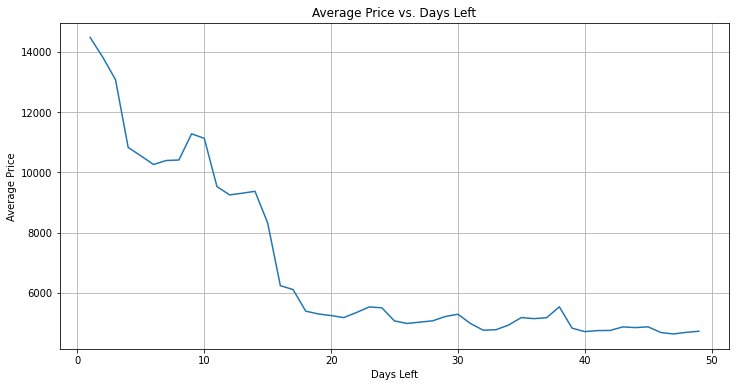

In [0]:
# Convert to Pandas DataFrame for visualization
avg_price_days_left_pd = df.groupBy('days_left').avg('price').orderBy('days_left').toPandas()

# Plotting
plt.figure(figsize=[12, 6])
sns.lineplot(data=avg_price_days_left_pd, x='days_left', y='avg(price)')
plt.title('Average Price vs. Days Left')
plt.xlabel('Days Left')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

#### Average duration vs source city

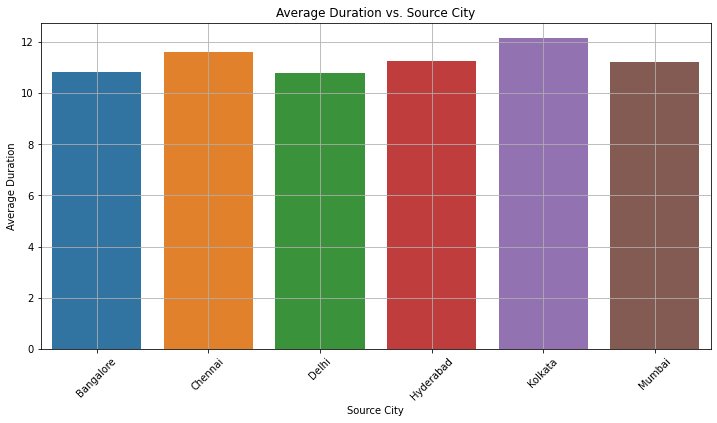

In [0]:
# Convert to Pandas DataFrame for visualization
avg_duration_source_city_pd = df.groupBy('source_city').avg('duration').orderBy('source_city').toPandas()

# Plotting
plt.figure(figsize=[12, 6])
sns.barplot(data=avg_duration_source_city_pd, x='source_city', y='avg(duration)')
plt.title('Average Duration vs. Source City')
plt.xlabel('Source City')
plt.ylabel('Average Duration')
plt.xticks(rotation=45)  # Rotate for better readability
plt.grid(True)
plt.show()

#### Average price vs duration

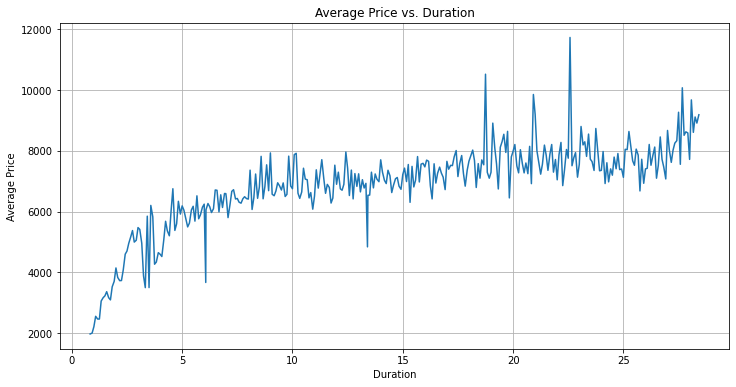

In [0]:
# Convert to Pandas DataFrame for visualization
avg_price_duration_pd = df.groupBy('duration').avg('price').orderBy('duration').toPandas()

# Plotting
plt.figure(figsize=[12, 6])
sns.lineplot(data=avg_price_duration_pd, x='duration', y='avg(price)')
plt.title('Average Price vs. Duration')
plt.xlabel('Duration')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

#### Correlation

DenseMatrix([[ 1.        , -0.03233383,  0.26364015],
             [-0.03233383,  1.        , -0.5593477 ],
             [ 0.26364015, -0.5593477 ,  1.        ]])


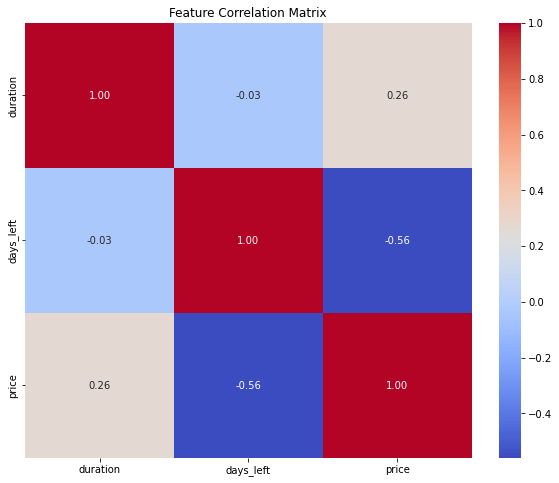

In [0]:


# Convert to vector column first 
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['duration', 'days_left', 'price'], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
correlation_matrix = matrix.collect()[0][0]
print(str(correlation_matrix).replace('nan', 'NaN'))

# Convert to Pandas DataFrame for easier manipulation and visualization
corr_df = pd.DataFrame(correlation_matrix.toArray(), 
                       columns=['duration', 'days_left', 'price'], 
                       index=['duration', 'days_left', 'price'])

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

###### Interpretation:

Based on the correlation matrix above, we can observe the following:

The feature "price" has a strong positive correlation with "days_left" (0.56) and a weak positive correlation with "duration" (0.26).
"days_left" and "duration" have a moderate negative correlation (-0.56).
The diagonal elements of the matrix have a value of 1.0, which represents the perfect correlation of each feature with itself.

The correlation matrix provides insights into the relationships between the features:

The positive correlation between "price" and "days_left" suggests that as the price increases, the number of days left tends to increase as well.
The negative correlation between "days_left" and "duration" indicates that as the duration increases, the number of days left tends to decrease.
The weak positive correlation between "price" and "duration" suggests a slight tendency for higher prices to be associated with longer durations.
These correlations can be useful for feature selection, as highly correlated features may provide redundant information and can potentially be removed to simplify the model. However, the decision to include or exclude features should also consider their relevance to the problem domain and the specific goals of the analysis.

#### EDA Visualization

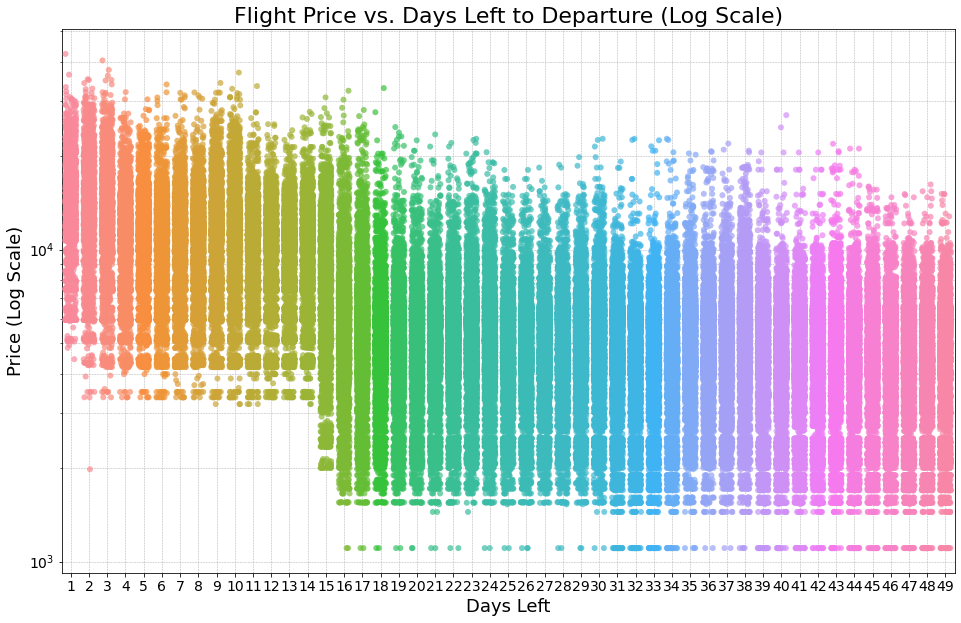

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Set the figure size for good readability
plt.figure(figsize=(16, 10))

# Adding jitter and plotting on a log scale for price
sns.stripplot(x='days_left', y='price', data=pandas_df, jitter=0.3, dodge=True, alpha=0.7, size=6)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Add grid lines and customize further for clarity
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Flight Price vs. Days Left to Departure (Log Scale)', fontsize=22)
plt.xlabel('Days Left', fontsize=18)
plt.ylabel('Price (Log Scale)', fontsize=18)
plt.xticks(fontsize=14)  # Increase x-axis tick size
plt.yticks(fontsize=14)  # Increase y-axis tick size

# Show the plot
plt.show()

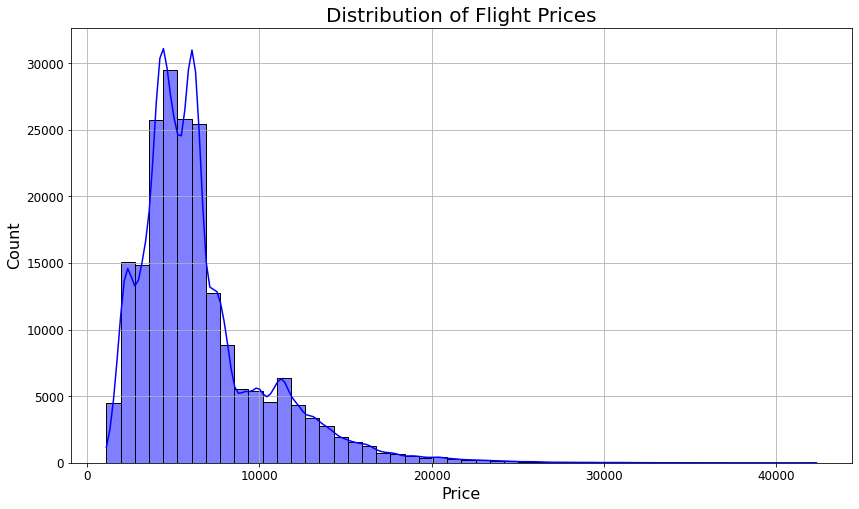

In [0]:
plt.figure(figsize=(14, 8))  # Setting the figure size for better readability

# Create the histogram
sns.histplot(pandas_df['price'], bins=50, kde=True, color='blue')  # Adjust 'bins' as needed

# Enhance the plot
plt.title('Distribution of Flight Prices', fontsize=20)  # Adding a title
plt.xlabel('Price', fontsize=16)  # X-axis label
plt.ylabel('Count', fontsize=16)  # Y-axis label

plt.xticks(fontsize=12)  # Increase x-axis tick size
plt.yticks(fontsize=12)  # Increase y-axis tick size

plt.grid(True)  # Add grid for better readability
plt.show()

## Model Training and Evaluation

We train and evaluate three regression models: Linear Regression, Random Forest Regression, and Gradient Boosted Tree Regression using the provided flight dataset. After converting the 'price' column to float type and splitting the data into training and testing sets, we assemble the features using VectorAssembler. For each model, we define the evaluation metric as root mean squared error (RMSE) and set up parameter grids for hyperparameter tuning. We then perform cross-validation to train the models and select the best hyperparameters. Finally, we evaluate the models on the test data and print the RMSE along with the best parameters for each model.

In [0]:
# Define and apply the VectorAssembler to create feature vectors
feature_cols = ["duration", "days_left"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
def setup_models():
    lr = LinearRegression(labelCol="price")
    dt = DecisionTreeRegressor(labelCol="price")
    rf = RandomForestRegressor(labelCol="price")

    lr_params = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.01, 0.1])\
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

    dt_params = ParamGridBuilder()\
        .addGrid(dt.maxDepth, [3, 5, 7])\
        .addGrid(dt.minInstancesPerNode, [1, 2, 4]).build()

    rf_params = ParamGridBuilder()\
        .addGrid(rf.numTrees, [10, 50, 100])\
        .addGrid(rf.maxDepth, [3, 5, 7]).build()

    return [(lr, lr_params), (dt, dt_params), (rf, rf_params)]

In [0]:
def train_and_evaluate_model(model, param_grid, train_data, test_data):
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3)
    cvModel = crossval.fit(train_data)
    predictions = cvModel.transform(test_data)
    rmse = evaluator.evaluate(predictions)
    return cvModel, rmse

In [0]:
best_rmse = float("inf")
best_model = None
best_model_name = ""

for model, params in setup_models():
    print(f"\nTraining {model.__class__.__name__}")
    cvModel, rmse = train_and_evaluate_model(model, params, train_data, test_data)
    print(f"RMSE on test data for {model.__class__.__name__}: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = cvModel.bestModel
        best_model_name = model.__class__.__name__

    print("Best parameters for", model.__class__.__name__, ":")
    for param, value in cvModel.bestModel.extractParamMap().items():
        print(f"{param.name}: {value}")

print(f"\nBest model is {best_model_name} with RMSE: {best_rmse}")


Training LinearRegression


In [0]:
model_path = "dbfs:/mnt/models/RFforFlightPrices"

# Save the best model
best_model.save(model_path)

print(f"Best model saved to {model_path}")

Best model saved to dbfs:/mnt/models/RFforFlightPrices


#### Model Selection: Random Forest Regressor

After evaluating multiple regression models, including Linear Regression, Decision Tree Regressor, and Random Forest Regressor, we have chosen Random Forest Regressor as the underlying model for our flight recommendation system. This decision was based on its strong predictive performance. Random Forest Regressor also offers significantly faster processing time and less risk of overfitting than GBT (Gradient Boosted Trees), which was tested and eliminated during a prior version of this project due to computational resource constraints. GBT and Random Forest had similar RMSE outputs for the best model fit, and Random Forest ran significantly faster.



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressionModel 

# Initialize a Spark session
spark = SparkSession.builder.appName("FlightPricePrediction").getOrCreate()

# Assuming these are the categorical and numerical feature names used during model training
categorical_features = ['departure_city', 'destination_city']
numerical_features = ['days_left', 'duration']

# User inputs
departure_city = input("Enter your departure city: ")
destination_city = input("Enter your destination city: ")
days_left = float(input("Enter the number of days left until the flight: "))
duration = float(input("Enter the flight duration in hours: "))

# Create a DataFrame with the input data
schema = StructType([
    StructField("departure_city", StringType(), True),
    StructField("destination_city", StringType(), True),
    StructField("days_left", FloatType(), True),
    StructField("duration", FloatType(), True)
])
new_data = spark.createDataFrame([(departure_city, destination_city, days_left, duration)], schema)

# Data processing and feature engineering
# Remember to replace these StringIndexer models with the ones you trained and saved during your model training phase
string_indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed", handleInvalid="keep").fit(new_data) 
                   for column in categorical_features]

# Apply the StringIndexer transformations
for indexer in string_indexers:
    new_data = indexer.transform(new_data)

# Assemble the features into a vector
assembler = VectorAssembler(
    inputCols=[col + "_indexed" for col in categorical_features] + numerical_features, 
    outputCol="features"
)

# Transform the data to have the 'features' column
new_data = assembler.transform(new_data)

# Load the RandomForestRegressionModel
trained_model = RandomForestRegressionModel.load("dbfs:/mnt/models/RFforFlightPrices")

# Make predictions using the transformed data
predictions = trained_model.transform(new_data)

# Selecting and showing the desired output
selected_cols = ["departure_city", "destination_city", "days_left", "duration", "prediction"]
predictions.select(selected_cols).show()


Enter your departure city:  Mumbai

Enter your destination city:  Delhi

Enter the number of days left until the flight:  6

Enter the flight duration in hours:  12

+--------------+----------------+---------+--------+-----------------+
|departure_city|destination_city|days_left|duration|       prediction|
+--------------+----------------+---------+--------+-----------------+
|        Mumbai|           Delhi|      6.0|    12.0|7443.036458290094|
+--------------+----------------+---------+--------+-----------------+



### Tracking the Utility Score of all airlines, destination/departure combined

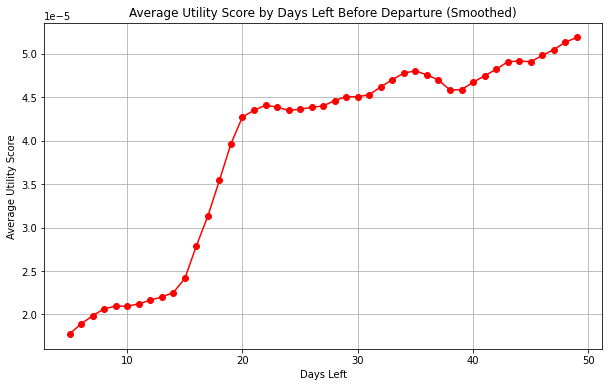

In [0]:

from pyspark.sql.functions import expr  # Add this line for the expr function

df = df.withColumn("utility_score", expr("1 / (price * duration)"))

pd_avg_utility_by_days_left = pd_avg_utility_by_days_left.sort_values(by='days_left')

# Calculate a rolling mean for smoothing purposes
window_size = 5  # Change this based on your dataset size and variability
pd_avg_utility_by_days_left['rolling_avg'] = pd_avg_utility_by_days_left['avg_utility_score'].rolling(window=window_size).mean()

# Plotting the smoothed average utility score against days left
plt.figure(figsize=(10, 6))
plt.plot(pd_avg_utility_by_days_left['days_left'], pd_avg_utility_by_days_left['rolling_avg'], marker='o', color='red')  # This plots the smoothed line
plt.title('Average Utility Score by Days Left Before Departure (Smoothed)')
plt.xlabel('Days Left')
plt.ylabel('Average Utility Score')
plt.grid(True)
plt.show()

In [0]:

# Group by 'airline' and 'days_left' and calculate average 'utility_score'
avg_utility_by_airline_days = df.groupBy('airline', 'days_left').agg(
    F.avg('utility_score').alias('avg_utility_score')
).orderBy('airline', 'days_left')

# Show the results (you might want to show more rows to get a better overview)
avg_utility_by_airline_days.show(50)

+---------+---------+--------------------+
|  airline|days_left|   avg_utility_score|
+---------+---------+--------------------+
|  AirAsia|        1|2.247420998034837E-5|
|  AirAsia|        2|3.075004746097038E-5|
|  AirAsia|        3|3.811287873613184E-5|
|  AirAsia|        4|3.737598611514073E-5|
|  AirAsia|        5|3.614277793172421E-5|
|  AirAsia|        6|3.003406778090409...|
|  AirAsia|        7|3.338803364801149...|
|  AirAsia|        8|2.997087745103178...|
|  AirAsia|        9|3.465094366612661E-5|
|  AirAsia|       10|3.205962067203953...|
|  AirAsia|       11|3.078604069378715E-5|
|  AirAsia|       12|3.276009122595202E-5|
|  AirAsia|       13|3.156133929137075...|
|  AirAsia|       14|3.147168473475722E-5|
|  AirAsia|       15|3.729145085667474E-5|
|  AirAsia|       16|6.156435943678286E-5|
|  AirAsia|       17|6.287653204015306E-5|
|  AirAsia|       18|6.654751628630403E-5|
|  AirAsia|       19|6.946044420123141E-5|
|  AirAsia|       20|6.850697731741224E-5|
|  AirAsia|

### Breaking Down Utility Score by Airline and Days until Departure

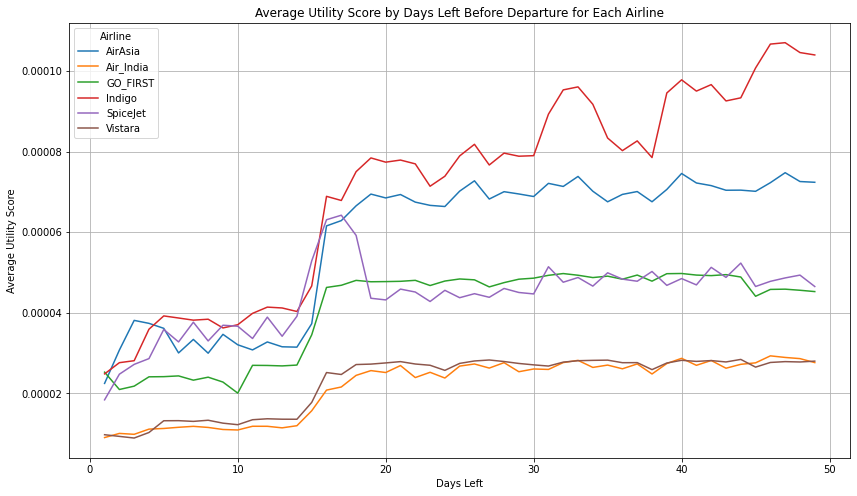

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pd_avg_utility_by_airline_days = avg_utility_by_airline_days.toPandas()

# Pivot the DataFrame for easier plotting
pivot_df = pd_avg_utility_by_airline_days.pivot(index='days_left', columns='airline', values='avg_utility_score')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, dashes=False)
plt.title('Average Utility Score by Days Left Before Departure for Each Airline')
plt.xlabel('Days Left')
plt.ylabel('Average Utility Score')
plt.legend(title='Airline')
plt.grid(True)
plt.show()

#### Identifying top Destination/Departure city pairs

In [0]:

# Count flights for each city pair and order by count
top_city_pairs = df.groupBy('source_city', 'destination_city').count().orderBy(F.desc('count'))

# Select the top 5 city pairs
top_city_pairs = top_city_pairs.limit(5)

# Collect city pairs into a list for filtering in subsequent steps
top_city_pairs_list = [(row['source_city'], row['destination_city']) for row in top_city_pairs.collect()]

#### Plotting utility scores for individual airlines, departure/destination pairs, days until departure

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


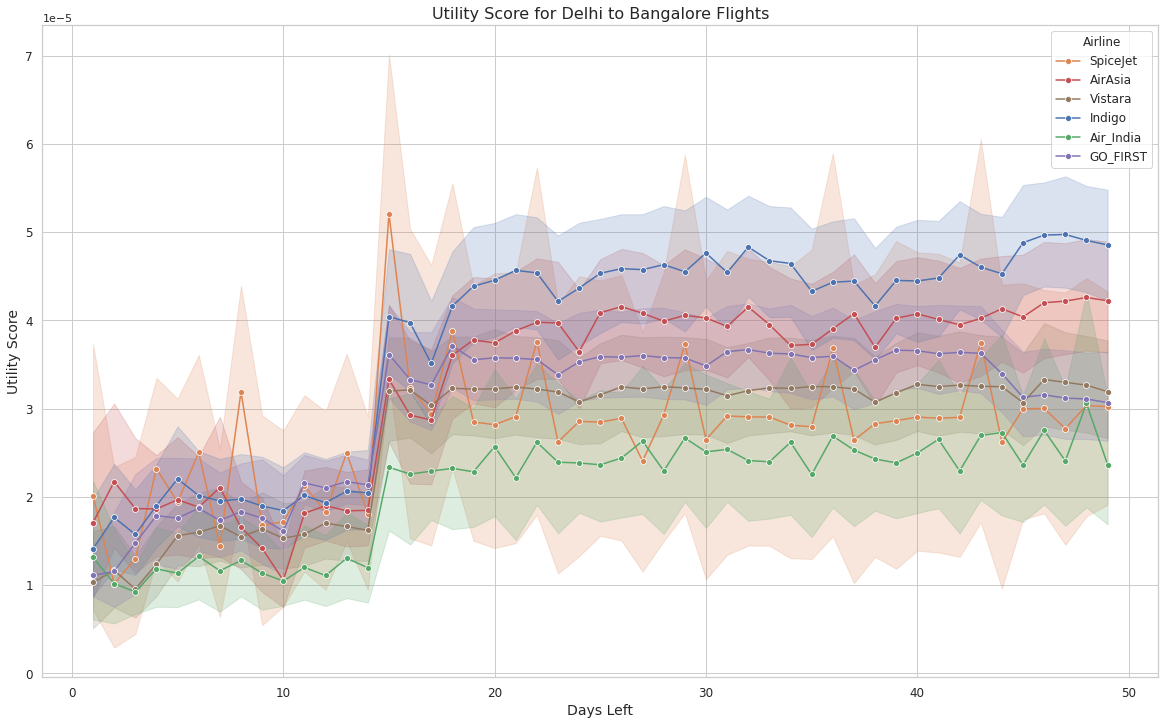

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


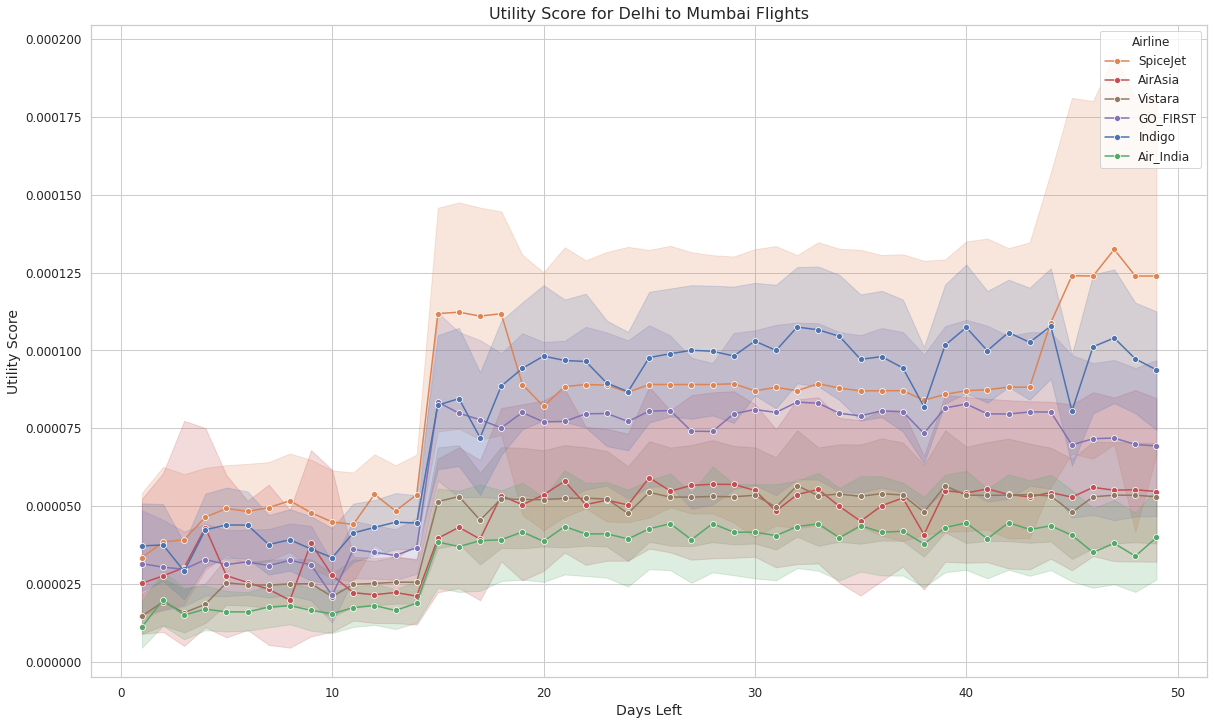

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


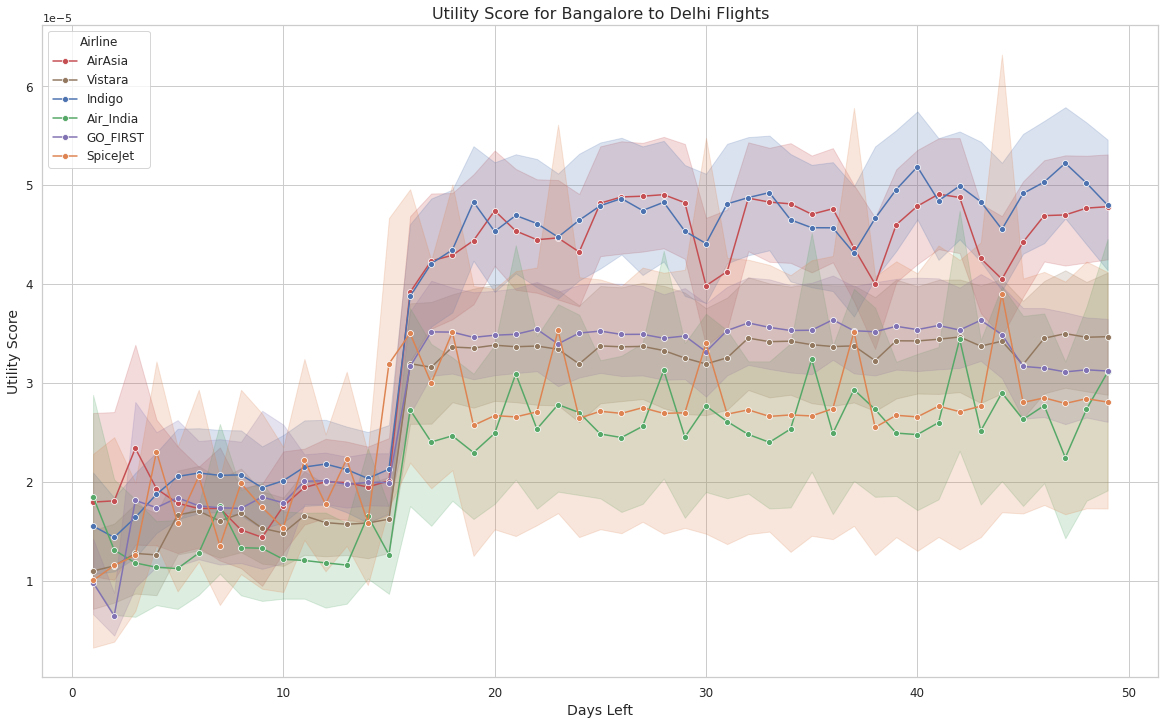

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


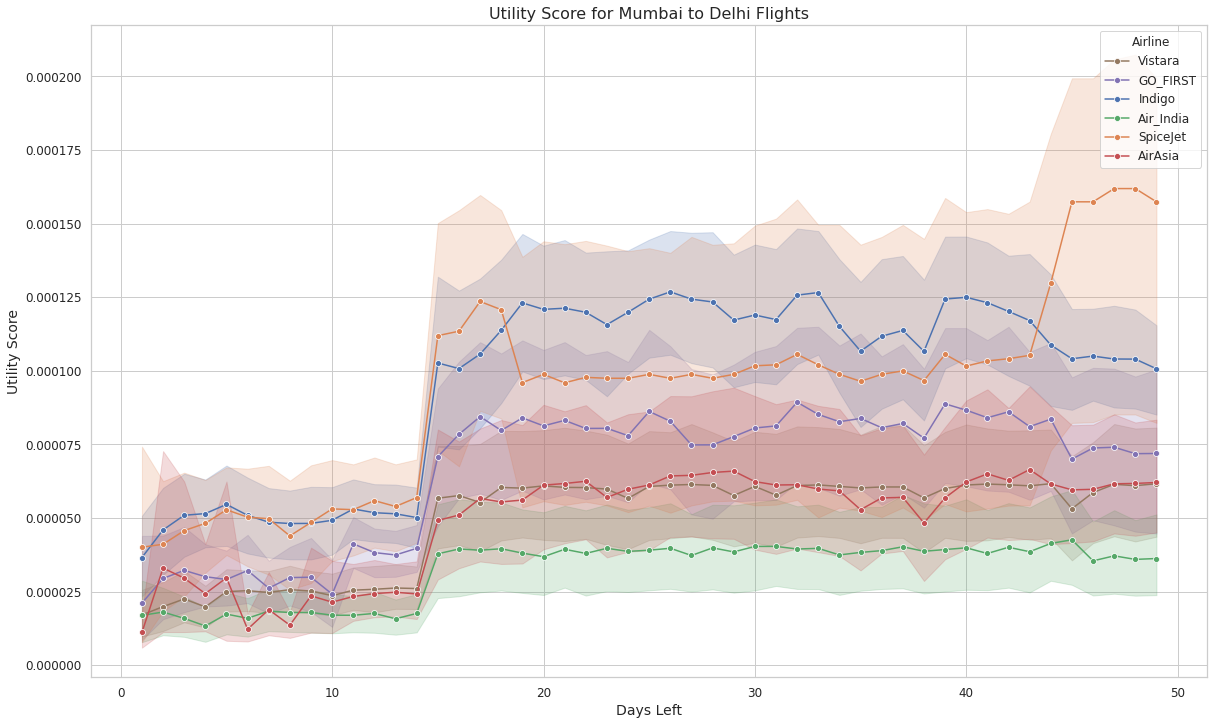

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


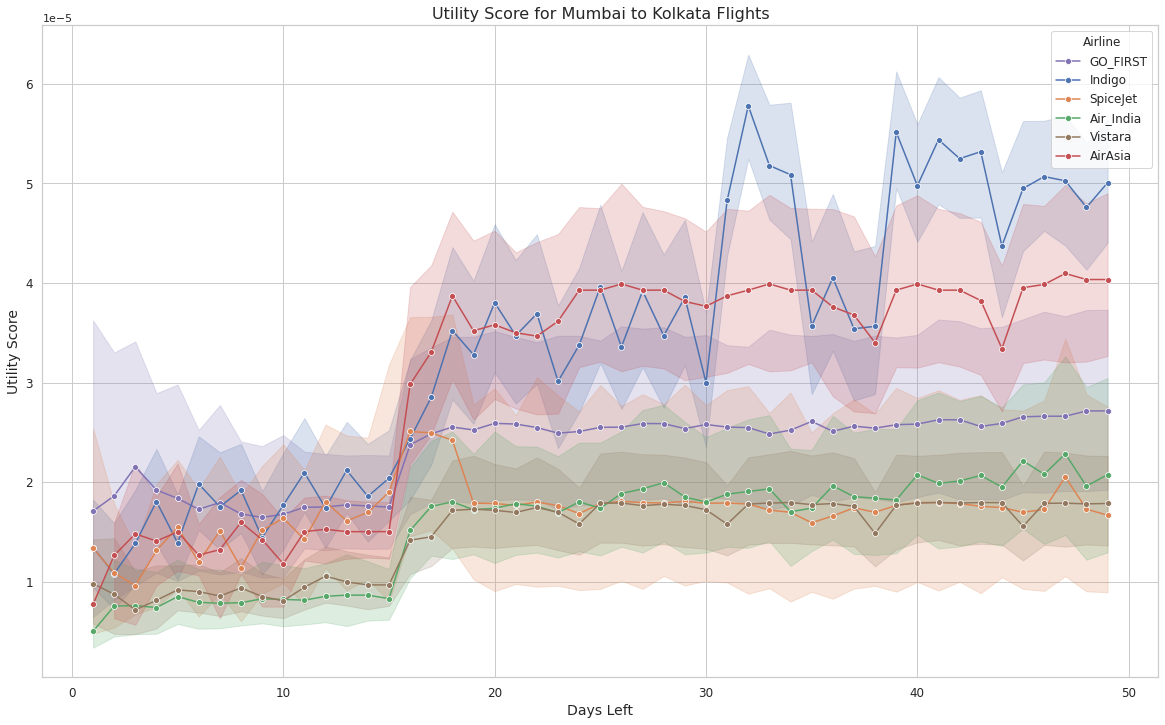

In [0]:
# Get unique values for the 'airline' column
unique_airlines = df.select('airline').distinct().collect()

# Convert the list of Row objects to a list of airline names
unique_airline_names = [row['airline'] for row in unique_airlines]

# Set plot style
sns.set(style="whitegrid")

# Create a color palette for airlines
airline_colors = {airline: color for airline, color in zip(unique_airline_names, sns.color_palette(n_colors=len(unique_airline_names)))}

# Iterate through the top city pairs
for i, city_pair in enumerate(top_city_pairs_list):
    # Filter data for the current city pair
    filtered_data = df.filter(
        (F.col('source_city') == city_pair[0]) & (F.col('destination_city') == city_pair[1])
    )
    
    # Convert to Pandas DataFrame for plotting
    pd_filtered_data = filtered_data.toPandas()
    
    # Create a new figure for each city pair
    plt.figure(figsize=(20, 12))
    
    # Plot each airline separately to assign colors
    for airline in pd_filtered_data['airline'].unique():
        airline_data = pd_filtered_data[pd_filtered_data['airline'] == airline]
        sns.lineplot(data=airline_data, x='days_left', y='utility_score', label=airline, color=airline_colors.get(airline, 'gray'), marker='o')
    
    # Set the title and labels with larger font sizes
    plt.title(f"Utility Score for {city_pair[0]} to {city_pair[1]} Flights", fontsize=16)
    plt.xlabel('Days Left', fontsize=14)
    plt.ylabel('Utility Score', fontsize=14)
    plt.legend(title='Airline', fontsize=12)
    
    # Adjust tick label font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot as a separate image file
    plt.savefig(f"utility_score_{city_pair[0]}_to_{city_pair[1]}.png")
    

    plt.show()